In [1]:
import numpy as np
import torch
from torch import nn
from torch.nn import functional
import matplotlib.pyplot as plt

# example 1: identify a ricker wavelet in a time-series

In [2]:
def ricker(t, sigma, t0=0, amplitude=1):
    t = t-t0
    return amplitude * 2/(np.sqrt(3*sigma)*np.pi**0.25) * (1 - (t/sigma)**2)*np.exp(-t**2/(2*sigma**2))

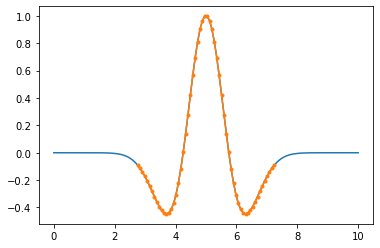

In [53]:
sigma = 0.75
t0 = 5
t = np.linspace(0, 10, 128)
time_series = ricker(t, sigma, t0)

t_ricker = t0 + 3*np.r_[-sigma, sigma]
ricker_inds = (t>=t_ricker.min()) & (t<=t_ricker.max())

plt.plot(t, time_series)
plt.plot(t[ricker_inds], time_series[ricker_inds], '-', marker=".")

## generate data

In [54]:
nt = 256
t = np.linspace(0, 10, nt)
sigma_bounds = np.r_[0.1, 0.5]
amplitude_bounds = np.r_[1, 1]
t0_bounds = np.r_[0.1, 9.9]

sigma_threshold = 3

In [55]:
def generate_random_variables(bounds, n):
    return bounds.min() + (bounds.max() - bounds.min()) * np.random.rand(n)

In [56]:
n_train = 512

sigma_train = generate_random_variables(sigma_bounds, n_train)
amplitude_train = generate_random_variables(sigma_bounds, n_train)
t0_train = generate_random_variables(t0_bounds, n_train)

In [57]:
def generate_data(sigma, t0, amplitude):
    n = len(sigma)
    X = torch.zeros(n, len(t))
    C = torch.zeros(n, len(t))
    
    for i in range(n):
        xi = ricker(t, sigma[i], t0[i], amplitude[i])
        t_ricker = t0[i] + sigma_threshold*np.r_[-sigma[i], sigma[i]]
        ci = ((t>=t_ricker.min()) & (t<=t_ricker.max()))
        
        X[i, :] = torch.from_numpy(xi)
        C[i, :] = torch.from_numpy(ci)
    
    return X, C

In [58]:
X, C = generate_data(sigma_train, t0_train, amplitude_train)

In [59]:
# validation data 

n_valid = 512

sigma_valid = generate_random_variables(sigma_bounds, n_valid)
amplitude_valid = generate_random_variables(sigma_bounds, n_valid)
t0_valid = generate_random_variables(t0_bounds, n_valid)

X_valid, C_valid = generate_data(sigma_valid, t0_valid, amplitude_valid)

## plot a subset of the data

In [60]:
def plot_data(Xplot, Cplot, nplot=16, dA=1, ax=None):

    inds = np.random.randint(0, Xplot.size(0), nplot)
    
    if ax is None: 
        fig, ax = plt.subplots(1, 1)

    for i, ind in enumerate(inds):
        xi = dA * i + Xplot[ind, :].numpy()
        ci = (Cplot[ind, :].numpy()).astype(bool)
        ax.plot(t, xi, 'C0')
        ax.plot(t[ci], xi[ci], 'C1o', ms=2)

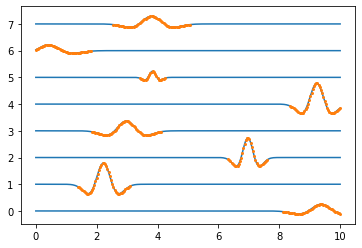

In [61]:
plot_data(X, C, 8)

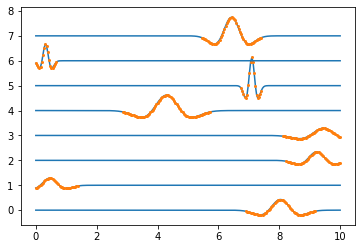

In [62]:
plot_data(X_valid, C_valid, 8)

# design a convolutional network

In [63]:
class ConvNet(nn.Module):
    
    def __init__(self, nt=1, h=0.1):
        super().__init__()
#         self.nt = nt
        self.h = h
    
    def forward(self, X, K, K0=None):
        X = X.unsqueeze(1)
        if K0 is not None:
            X = functional.conv1d(X, K0, stride=1, padding=1)
            
        for Ki in K: 
            z = functional.conv1d(X, Ki, stride=1, padding=1)
            z = functional.instance_norm(z)
            z = functional.relu(z)
            z = functional.conv_transpose1d(z, Ki, stride=1, padding=1)
            X = X - self.h*z
        return X

In [64]:
in_channels = 1
out_channels = 2

n_class = 2

batch_size = 32 
nlayers = 30
net = ConvNet()

# initialize K's
K0 = nn.Parameter(torch.Tensor(out_channels, in_channels, 3))
K0.data = torch.from_numpy(np.float32(np.random.randn(out_channels, in_channels, 3)))

K = []
for i in range(nlayers):
    Ki = nn.Parameter(torch.Tensor(out_channels, out_channels, 3))
    Ki.data = torch.from_numpy(np.float32(np.random.randn(out_channels, out_channels, 3)))
    K.append(Ki)

In [65]:
lossFunc = nn.CrossEntropyLoss()

def misfit(X, W,  C):
#     n = W.shape
#     X = X.view(-1, n[0])
#     print(X.shape, W.shape)
#     S = torch.matmul(X, W) 
#     print(C.shape, C.dtype)
#     S = X
#     print(S.shape, S.dtype)
#     S += bias.unsqueeze(1)
    return lossFunc(X, C.long()), X

In [66]:
# weights for linear classifier    
W = nn.Parameter(torch.randn(nt, 2*nt)*1e-3, requires_grad=True)
# bW = nn.Parameter(torch.randn(n_class)*1e-2, requires_grad=True)

nparout = np.prod(K0.shape) + np.prod(K[0].shape)*nlayers + nlayers

print('Total number of parameter',nparout)
print('Total number of data',C.shape[0])

Total number of parameter 396
Total number of data 512


In [67]:
x = net(X, K, K0)
label = C
loss, probs = misfit(x, W, label)
print('Initial loss = ', loss.detach().numpy())    
print('Sanity Check = ', np.log(2.0))

Initial loss =  0.80135757
Sanity Check =  0.6931471805599453


In [78]:
batchSize = 32

In [79]:
import torch.optim as optim
optimizer = optim.SGD(
    [{'params': K0}, {'params': K}], #{'params': W}, {'params': bW}, {'params': b}], 
    lr = 1e0, momentum=0
)


In [80]:
for epoch in range(40):  # loop over the dataset multiple times

    # zero the parameter gradients
    g = 0.0
    loss = 0.0
    ind = 0
    
    while ind < X.shape[1]:    
        optimizer.zero_grad()
        # get the inputs
        inputs = X[ind:ind+batchSize, :]
        labels = C[ind:ind+batchSize, :]

        # forward 
        x = net(inputs, K, K0)
        lossi, _ = misfit(x, W, labels)
        if i==0:
            loss = lossi
        else:
            loss += lossi
        
        lossi.backward()
        optimizer.step()
        g += torch.norm(K0.grad) + torch.norm(K[0].grad)    
        ind += batchSize
        
    print('%d  %.3f   %.3f'% (epoch+1, loss, g))

print('Finished Training')

1  1.301   0.324
2  1.309   0.742
3  1.317   0.807
4  1.222   0.957
5  1.321   0.814
6  1.197   0.367
7  1.188   0.447
8  1.203   0.647
9  1.307   0.562
10  1.160   0.621
11  1.102   0.637
12  1.222   0.657
13  1.105   0.456
14  1.141   0.764
15  1.174   0.725
16  1.097   0.442
17  1.060   0.477
18  1.118   0.535
19  1.064   0.502
20  1.051   0.445
21  1.030   0.359
22  1.021   0.434
23  1.031   0.446
24  0.947   0.262
25  0.948   0.508
26  1.029   0.521
27  1.006   0.363
28  0.931   0.469
29  0.952   0.473
30  0.975   0.458
31  0.929   0.392
32  0.988   0.762
33  0.988   0.541
34  0.956   0.766
35  0.890   0.314
36  0.927   0.541
37  0.942   0.818
38  0.831   0.330
39  0.947   0.471
40  0.852   0.365
Finished Training


In [81]:
xval = net(X_valid, K, K0)
# S = torch.matmul(W,x)
# S += bW.unsqueeze(1)
S = functional.softmax(xval, dim=1)
_, Cpred = torch.max(S, dim=1)

# label = C
# loss, S = misfit(x, W, bW, label)
# print('Validation loss = ', loss.detach().numpy()) 

# indRed = (Cpred==0).nonzero()
# indBlue = (Cpred==1).nonzero()

# plt.plot(XVal[0,indRed].numpy(),XVal[1,indRed].numpy(),'.C3')
# plt.plot(XVal[0,indBlue].numpy(),XVal[1,indBlue].numpy(),'.C0')

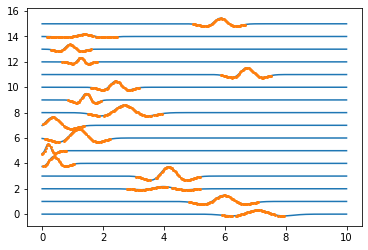

In [82]:
x_train_net = net(X, K, K0)
# S = torch.matmul(W,x)
# S += bW.unsqueeze(1)
S = functional.softmax(x_train_net, dim=1)
_, Cpred = torch.max(S, dim=1)
plot_data(X, Cpred, 16)

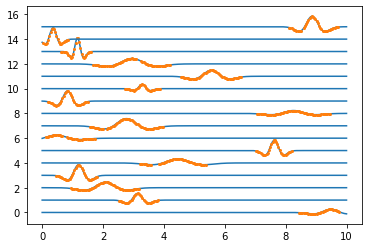

In [83]:
x_valid_net = net(X_valid, K, K0)
# S = torch.matmul(W,x)
# S += bW.unsqueeze(1)
S = functional.softmax(x_valid_net, dim=1)
_, Cpred_valid = torch.max(S, dim=1)
plot_data(X_valid, Cpred_valid, 16)

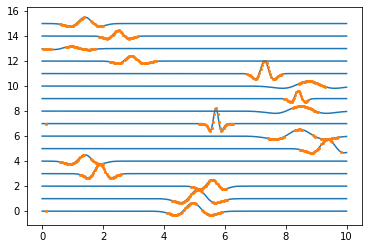

In [74]:
plot_data(X_valid, Cpred_valid, 16)